# Extra Notebooks Analyses


This notebooks has extra analyses related to notebooks. These analyses did not make into the paper.

In [1]:
import sys
sys.path.insert(0, '../archaeology')


import pandas as pd

from db import connect, Query
import analysis_helpers, importlib
importlib.reload(analysis_helpers)
from analysis_helpers import display_counts
from analysis_helpers import distribution_with_boxplot, fig


%matplotlib inline

## Query

Select asts and modules from:

- existing

  ```n.skip & 2048 = 0```

- valid
  
  ```NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
  AND n.processed & 15 = 0 AND n.skip & (1024 + 512) = 0```


- non-duplicated
  
  ```n.skip & (1024 + 512 + 128) = 0```

  

In [2]:
with connect() as session:
    print('Last query:', session.query(Query).all()[-1])
    non_duplicated = pd.read_sql("""
        SELECT n.*, m.python_2, m.python_3
        FROM notebooks n, notebooks_bool_aggregates m
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND m.notebook_id = n.id
    """, session.connection())
    print("Non duplicated notebooks:", len(non_duplicated))

Last query: <Query(language:"Jupyter Notebook" created:2018-04-16T03:56:05Z..2018-04-16T22:18:58Z)>
Non duplicated notebooks: 1024269


In [3]:
notebooks = non_duplicated

## nbformat

* 0 - The source indicates 2008-2011. 
* 2.0 - August, 2013 (?) - The documentation of IPython 1 mentions nbformat v2
* 3.0 - April, 2014 (?) - The documentation of IPython 2 mentions nbformat v3
* 4.0 - July, 2015 - First release of nbformat on its own package
* 4.1 - August, 2016
* 4.2 - December, 2016
* 4.3 - February, 2017
* 4.4 - Not released yet

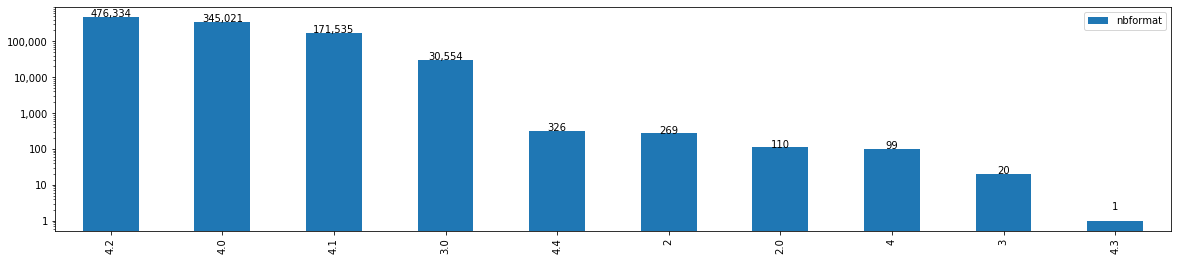

,nbformat
4.2,476334
4.0,345021
4.1,171535
3.0,30554
4.4,326
2,269
2.0,110
4,99
3,20
4.3,1


In [4]:
display_counts(notebooks["nbformat"].value_counts(), show_values=True)

## Programing Language

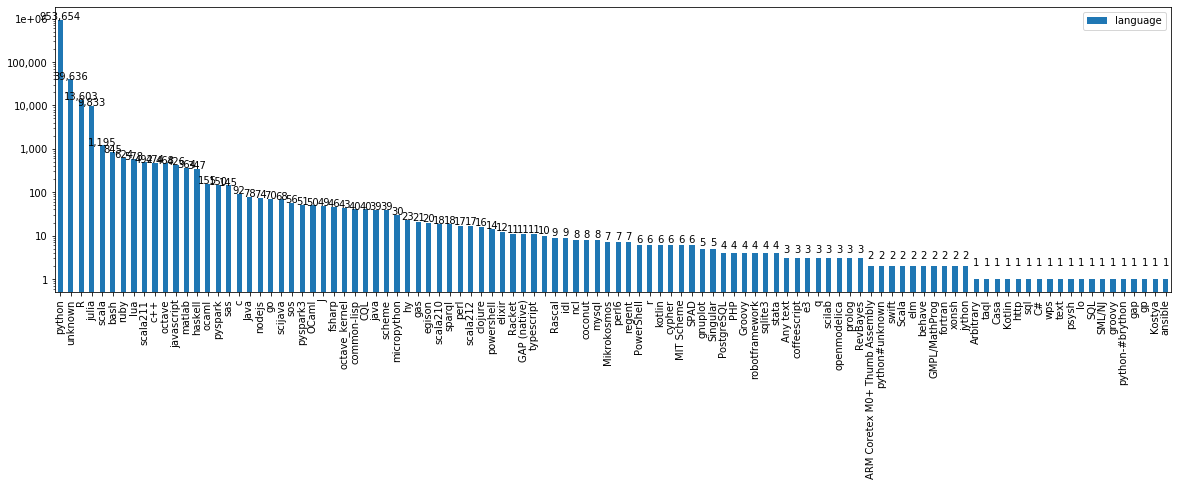

,language
python,953654
unknown,39636
R,13603
julia,9833
scala,1195
...,...
python-#brython,1
gap,1
gp,1
Kostya,1


In [5]:
display_counts(notebooks["language"].value_counts(), show_values=True)

### Python notebooks

In [6]:
python_notebooks = notebooks[
    notebooks["language"] == "python"
]
len(python_notebooks)

953654

#### By patch version

/home/joao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/joao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


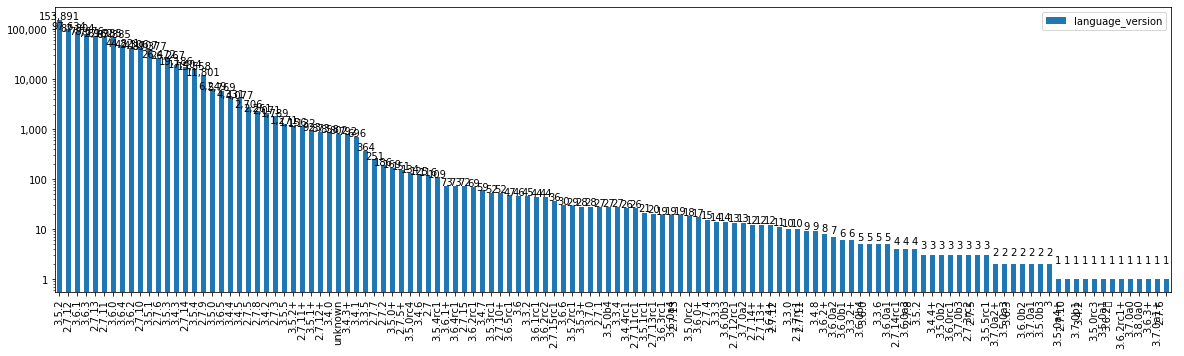

,language_version
3.5.2,153891
2.7.12,97634
3.6.1,87804
3.6.3,78676
2.7.13,72162
...,...
3.7.0a0,1
3.8.0a0,1
3.6.3+,1
3.7.0a1+,1


In [7]:
counts = python_notebooks["language_version"].value_counts()
display_counts(counts, show_values=True)

#### By minor version

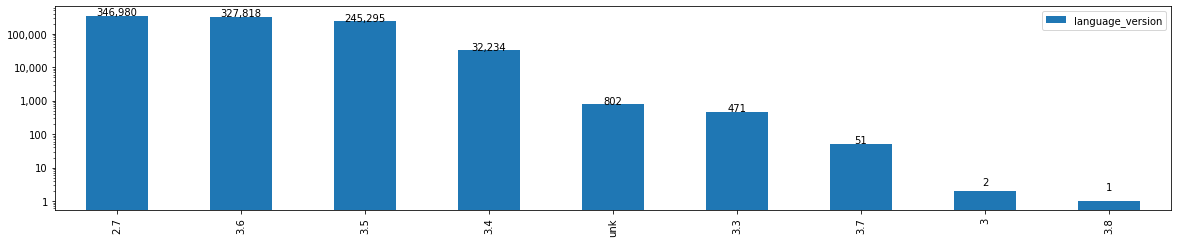

,language_version
2.7,346980
3.6,327818
3.5,245295
3.4,32234
unk,802
3.3,471
3.7,51
3,2
3.8,1


In [8]:
counts = python_notebooks["language_version"].str.slice(stop=3).value_counts()
display_counts(counts, show_values=True)

#### By major version

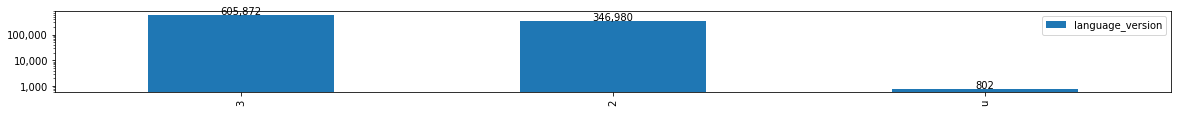

,language_version
3,605872
2,346980
u,802


In [9]:
counts = python_notebooks["language_version"].str.slice(stop=1).value_counts()
display_counts(counts, show_values=True)

## Execution Count

In [10]:
without_execution_numbers = notebooks[notebooks.max_execution_count < 0]
n_without_execution_numbers = len(without_execution_numbers)
print("Non executed notebooks:", n_without_execution_numbers)

Non executed notebooks: 91887


In [11]:
executed_notebooks = notebooks[notebooks["max_execution_count"] > -0]
print("Executed notebooks:", len(executed_notebooks))

Executed notebooks: 932382


### Python

In [12]:
without_execution_numbers = python_notebooks[python_notebooks.max_execution_count < 0]
n_without_execution_numbers = len(without_execution_numbers)
print("Non executed python notebooks:", n_without_execution_numbers)

Non executed python notebooks: 83317


In [13]:
print("Executed python notebooks:", len(
    python_notebooks[python_notebooks["max_execution_count"] > -0]
))

Executed python notebooks: 870337


### Executed cells

Distribution(min=0, q1=6.0, median=12.0, q3=22.0, max=702)


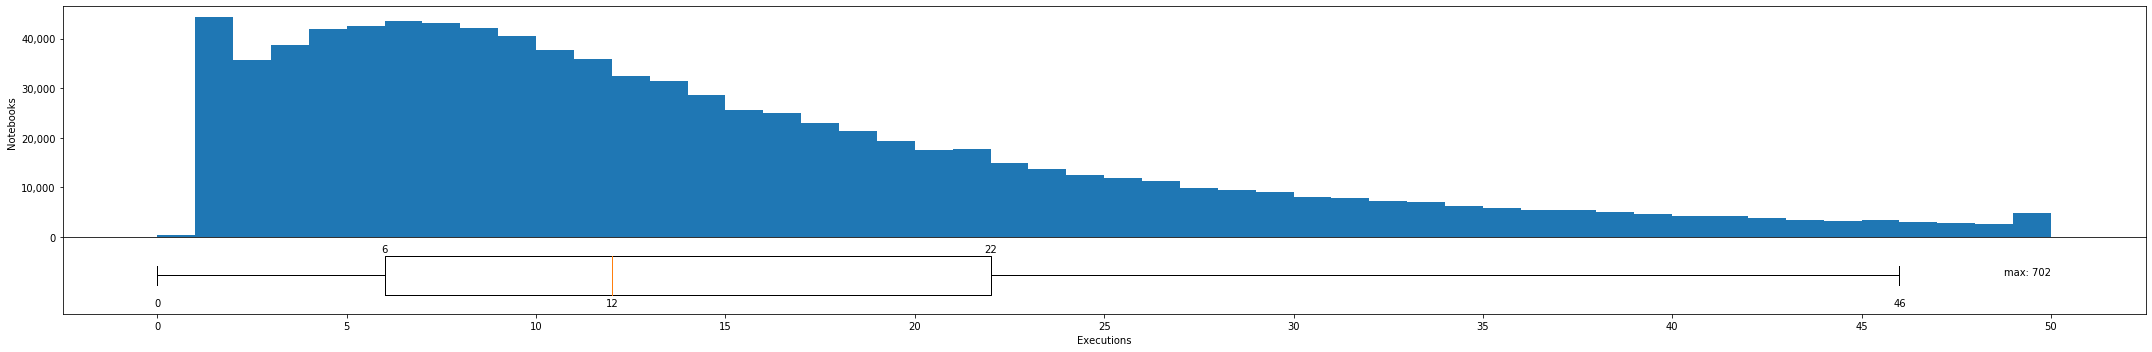

In [14]:
column = executed_notebooks[executed_notebooks["numeric_counts_total"] != -1]["numeric_counts_total"]
distribution = distribution_with_boxplot(column, 0, 50, 5, "Notebooks", "Executions",  True)
print(distribution)

In [15]:
total = len(executed_notebooks[
    executed_notebooks["numeric_counts_total"]
    != executed_notebooks["numeric_set_total"]
])
print("Notebooks with repeated numbers:", total)

Notebooks with repeated numbers: 125048


In [16]:
total = len(executed_notebooks[
    executed_notebooks["processing_cells"] > 0
])
print("Notebooks that stopped in the middle:", total)

Notebooks that stopped in the middle: 293


## Cells

Refer to A2.RQ1.RQ2 to other analysis on the number of code cells and markdown cells

### Number of cells

Distribution(min=1, q1=9.0, median=19.0, q3=37.0, max=1272)


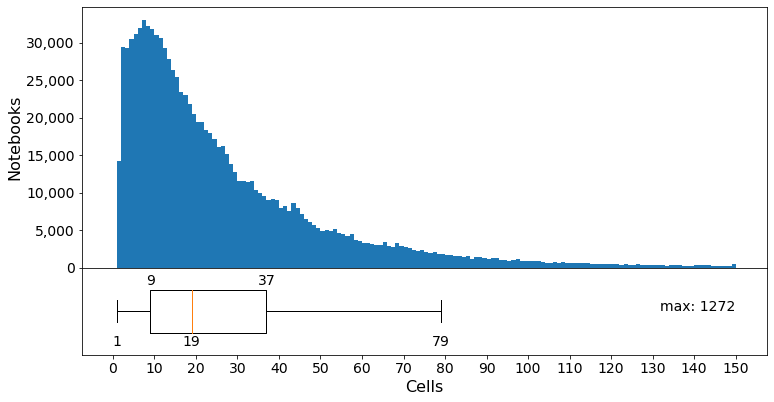

In [17]:
column = notebooks["total_cells"]
with fig("d_e2_total_cells", 10, 6):
    distribution = distribution_with_boxplot(column, 0, 150, 10, "Notebooks", "Cells",  True)
    print(distribution)  

### Code cells with outputs

Distribution(min=0, q1=1.0, median=3.0, q3=9.0, max=416)


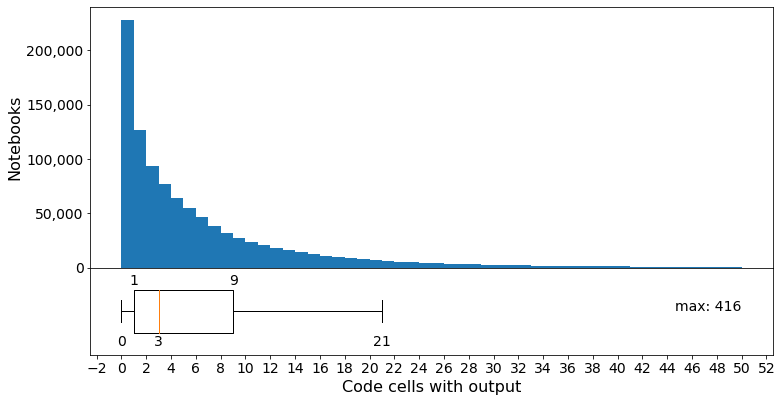

In [18]:
column = notebooks["code_cells_with_output"]
with fig("d_e2_code_cells_with_output", 10, 6):
    distribution = distribution_with_boxplot(column, 0, 50, 2, "Notebooks", "Code cells with output",  True)
    print(distribution)

### Raw cells

According to the [documentation](http://jupyter-notebook.readthedocs.io/en/latest/notebook.html), raw cells, let you write _output_ directly. Raw cells are not evaluated by the kernel and the nbconvert does not touch them

Distribution(min=0, q1=0.0, median=0.0, q3=0.0, max=137)


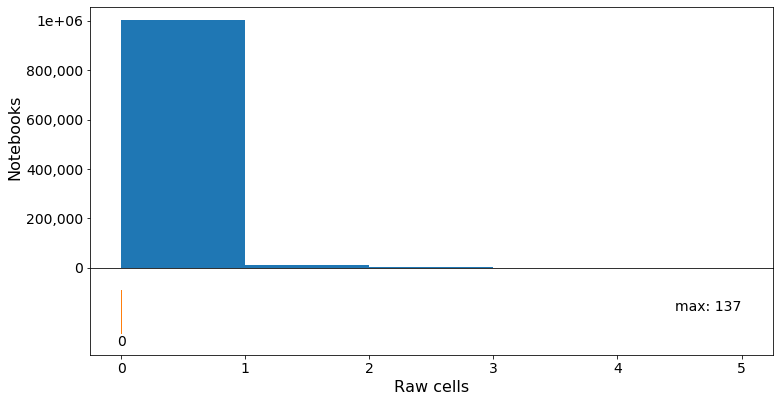

In [19]:
column = notebooks["raw_cells"]
with fig("d_e2_raw_cells", 10, 6):
    distribution = distribution_with_boxplot(column, 0, 5, 1, "Notebooks", "Raw cells",  True)
    print(distribution)

### Empty cells

Distribution(min=0, q1=0.0, median=1.0, q3=1.0, max=745)


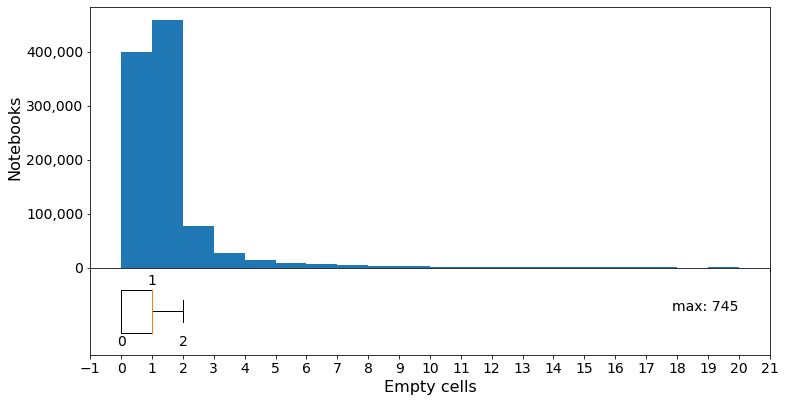

In [20]:
column = notebooks["empty_cells"]
with fig("d_e2_empty_cells", 10, 6):
    distribution = distribution_with_boxplot(column, 0, 20, 1, "Notebooks", "Empty cells",  True)
    print(distribution)

### Unknown cells formats

In [21]:
column = notebooks["unknown_cell_formats"]
column.sum()

1047

### Code cells vs max execution count distance

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Distribution(min=-593, q1=1.0, median=11.0, q3=46.0, max=10995)


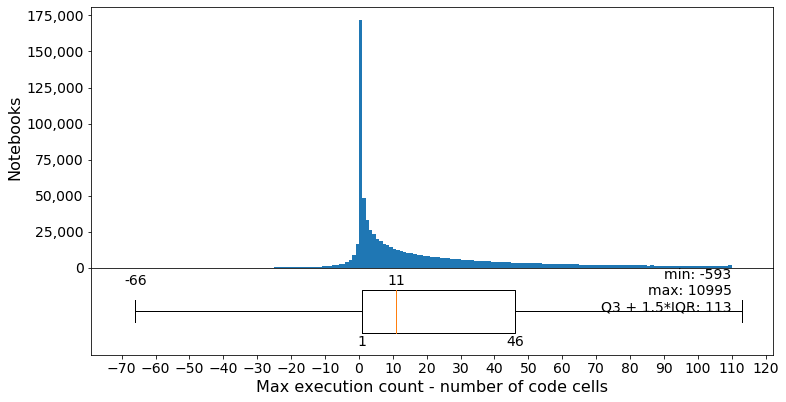

In [22]:
diff = (
    executed_notebooks["max_execution_count"]
    - executed_notebooks["code_cells"]
    + executed_notebooks["empty_cells"]
)
column = diff
with fig("d_e2_diff_execount_cells", 10, 6):
    distribution = distribution_with_boxplot(column, -70, 110, 10, "Notebooks", "Max execution count - number of code cells",  True)
    print(distribution)

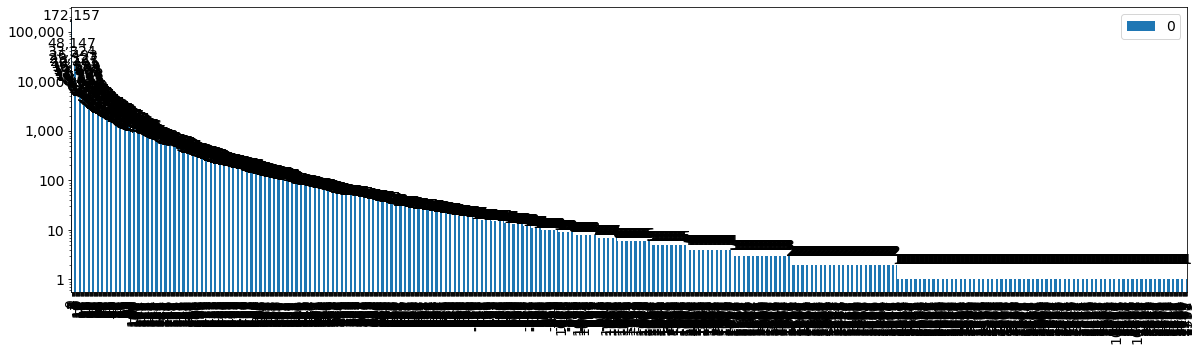

,0
0,172157
1,48147
2,33324
3,26493
4,23327
...,...
1755,1
2267,1
1752,1
1751,1


In [23]:
display_counts(diff.value_counts(), show_values=True)

#### Max execution count = number of non-empty code cells

In [24]:
print("{0:.2%}".format(
    len(diff[diff == 0])
    / len(executed_notebooks)
))

18.46%


#### More code cells than execution numbers

In [25]:
print("{0:.2%}".format(
    len(diff[diff < 0])
    / len(executed_notebooks)
))

6.38%


#### Less code cells than execution numbers

In [26]:
print("{0:.2%}".format(
    len(diff[diff > 0])
    / len(executed_notebooks)
))

75.15%


This notebook analyzed data from the notebooks, but we did not include any of them in the paper